<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
sys.path.append('/content/drive/My Drive/CS490')
sys.path.insert(0,'/content/drive/MyDrive/CS490/PyMO')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# not necessary if I will use https://github.com/omimo/PyMO.git
!pip install bvhtoolbox

In [34]:
%load /content/drive/MyDrive/CS490/PyMO/pymo/viz_tools.py
%load /content/drive/MyDrive/CS490/PyMO/pymo/parsers.py
%load /content/drive/MyDrive/CS490/PyMO/pymo/data.py
%load /content/drive/MyDrive/CS490/PyMO/pymo/viz_tools.py
%load /content/drive/MyDrive/CS490/PyMO/pymo/preprocessing.py

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
# import bvh
# import bvhtoolbox
# from bvhtoolbox import Bvh, BvhNode
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [36]:
import pymo.parsers as parsers
import pymo.viz_tools as viz_tools
import pymo.preprocessing as preprocessing

In [40]:
onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
emotions = np.array(['anger', 'joy', 'sadness'])
X = onehotencoder.fit_transform(emotions.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
print(X)
one_hot_dict = dict(zip(emotions, ))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [42]:
onehotencoder.inverse_transform([[1,0,0]])

array([['anger']], dtype='<U7')

In [47]:
onehotencoder.transform([['joy']]).toarray().reshape((-1))

array([0., 1., 0.])

In [121]:
# using PyMO, raw data for each emotion. do anger and joy for now.
# you don't keep pymo parsers. How visualize etc the data from pos and rotation values??
class Dataset(object):
  def __init__(
                self,
                emotions,   # names of the emotions. 
                # path to drive will be constant, go to the folder named the emotion and load all the files in it.
                path = '/content/drive/MyDrive/CS490/dataset',
                frames = 100  # equal sized videos.
    ):
    self.emotions = np.array(emotions).reshape((-1))
    self.onehotencoder = OneHotEncoder()
    self.encoded_emotions = onehotencoder.fit_transform(self.emotions.reshape(-1,1)).toarray()
    # to encode: onehotencoder.transform([['joy']]).toarray().reshape((-1))
    # to decode: onehotencoder.inverse_transform([[1,0,0]])
    self.Y = []
    self.Y_tmp = []
    self.X = []
    self.feature_names = []  
    self.position_data = []   # positions data will not be used, only keep 
    self.joint_names = []
    self.position_features = ['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition']

    parser = parsers.BVHParser()
    for emotion in emotions:
      data_path = path + '/' + str(emotion)
      file_names = os.listdir(data_path)
      encoded_emotion = onehotencoder.transform([[emotion]]).toarray().reshape((-1))
      for file_name in file_names:
        file_path = data_path + '/' + file_name
        parser.parse(file_path)          
        length = len(parser.data.values)
        no_of_parts = length // frames
        for i in range(no_of_parts):
          sample = parser.data.values[i * frames:(i+1) * frames]
          self.position_data.append(np.array(sample[self.position_features]))
          self.X.append(np.array(sample.drop(columns=self.position_features)))
          self.Y.append(np.repeat(encoded_emotion.reshape(-1,encoded_emotion.shape[0]), 100, axis=0))
          self.Y_tmp.append(encoded_emotion)
          
    for joint in parser.data.skeleton:
      self.joint_names.append(joint)

    self.feature_names = parser.data.values.columns.drop(self.position_features)

    self.X = np.array(self.X)
    self.Y = np.array(self.Y)
    self.Y_tmp = np.array(self.Y_tmp)
    self.position_data = np.array(self.position_data)
    return 

  def train_test_split(self, test_size = 0.33, shuffle = True):
    X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y_tmp, test_size=test_size, random_state=42, shuffle=shuffle)
    return X_train, X_test, Y_train, Y_test

In [122]:
dataset = Dataset(['anger', 'joy'])

In [102]:
dataset.Y.shape

(526, 100, 2)

In [103]:
dataset.X.shape

(526, 100, 69)

In [123]:
X_train, X_test, Y_train, Y_test = dataset.train_test_split()

In [136]:
# Keras LSTM model with 2 LSTM layers with input shape = (3,13) for 3 euler rotations per for each of the 13 joints.
# And 1 fully-connected layer with sigmoid activation layer at the end to output intensities.
# output shape = ?
# a second lstm layer ???
model = keras.Sequential()
model.add(layers.LSTM(100, input_shape=(100,69), activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# , metrics=['accuracy', 'TruePositives', 'FalseNegatives', 'FalsePositives', 'TrueNegatives']

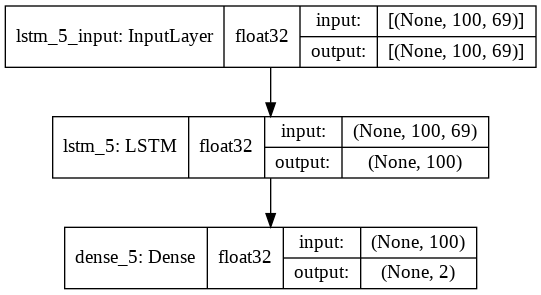

In [61]:
# model structure visualization
utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
)

In [130]:
Y_train.shape

(352, 2)

In [131]:
Y_train_2 = Y_train.reshape(-1,352,2)

In [129]:
X_train.shape

(352, 100, 69)

In [137]:
history = model.fit(X_train, Y_train, epochs = 100, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/100
10/10 - 2s - loss: nan - accuracy: 0.6614 - val_loss: nan - val_accuracy: 0.7222
Epoch 2/100
10/10 - 1s - loss: nan - accuracy: 0.6646 - val_loss: nan - val_accuracy: 0.7222
Epoch 3/100
10/10 - 1s - loss: nan - accuracy: 0.6646 - val_loss: nan - val_accuracy: 0.7222
Epoch 4/100
10/10 - 1s - loss: nan - accuracy: 0.6646 - val_loss: nan - val_accuracy: 0.7222
Epoch 5/100
10/10 - 1s - loss: nan - accuracy: 0.6646 - val_loss: nan - val_accuracy: 0.7222
Epoch 6/100
10/10 - 1s - loss: nan - accuracy: 0.6646 - val_loss: nan - val_accuracy: 0.7222
Epoch 7/100
10/10 - 1s - loss: nan - accuracy: 0.6646 - val_loss: nan - val_accuracy: 0.7222
Epoch 8/100
10/10 - 1s - loss: nan - accuracy: 0.6646 - val_loss: nan - val_accuracy: 0.7222
Epoch 9/100
10/10 - 1s - loss: nan - accuracy: 0.6646 - val_loss: nan - val_accuracy: 0.7222
Epoch 10/100
10/10 - 1s - loss: nan - accuracy: 0.6646 - val_loss: nan - val_accuracy: 0.7222
Epoch 11/100
10/10 - 1s - loss: nan - accuracy: 0.6646 - val_loss: na

In [17]:
# split a univariate sequence into samples
def split_sequence(sequence, frames):
  X, y = list(), list()
  for i in range(sequence.shape[0]):
    # find the end of this pattern
    end_ix = i + frames
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X).reshape(-1, np.array(X).shape[1], 1), np.array(y).reshape(-1, 1)

In [ ]:
anger_parser.data.values

,Hips_Xposition,Hips_Yposition,Hips_Zposition,Hips_Yrotation,Hips_Xrotation,Hips_Zrotation,Chest_Yrotation,Chest_Xrotation,Chest_Zrotation,Chest2_Yrotation,Chest2_Xrotation,Chest2_Zrotation,Chest3_Yrotation,Chest3_Xrotation,Chest3_Zrotation,Chest4_Yrotation,Chest4_Xrotation,Chest4_Zrotation,Neck_Yrotation,Neck_Xrotation,Neck_Zrotation,Head_Yrotation,Head_Xrotation,Head_Zrotation,RightCollar_Yrotation,RightCollar_Xrotation,RightCollar_Zrotation,RightShoulder_Yrotation,RightShoulder_Xrotation,RightShoulder_Zrotation,RightElbow_Yrotation,RightElbow_Xrotation,RightElbow_Zrotation,RightWrist_Yrotation,RightWrist_Xrotation,RightWrist_Zrotation,LeftCollar_Yrotation,LeftCollar_Xrotation,LeftCollar_Zrotation,LeftShoulder_Yrotation,LeftShoulder_Xrotation,LeftShoulder_Zrotation,LeftElbow_Yrotation,LeftElbow_Xrotation,LeftElbow_Zrotation,LeftWrist_Yrotation,LeftWrist_Xrotation,LeftWrist_Zrotation,RightHip_Yrotation,RightHip_Xrotation,RightHip_Zrotation,RightKnee_Yrotation,RightKnee_Xrotation,RightKnee_Zrotation,RightAnkle_Yrotation,RightAnkle_Xrotation,RightAnkle_Zrotation,RightToe_Yrotation,RightToe_Xrotation,RightToe_Zrotation,LeftHip_Yrotation,LeftHip_Xrotation,LeftHip_Zrotation,LeftKnee_Yrotation,LeftKnee_Xrotation,LeftKnee_Zrotation,LeftAnkle_Yrotation,LeftAnkle_Xrotation,LeftAnkle_Zrotation,LeftToe_Yrotation,LeftToe_Xrotation,LeftToe_Zrotation
0 days 00:00:00,0.000000,85.388000,0.000000,0.000000,-5.767877,0.000000,0.000000,11.653817,0.000000,0.000000,-5.885947,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,12.528835,0.000000,0.000000,0.711642,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-90.000000,0.000000,-2.309062,0.000000,0.000000,2.309062,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,90.000000,0.000000,-2.309062,0.000000,0.000000,2.309062,0.000000,0.000000,8.520406,0.000000,0.000000,1.905762,0.000000,-0.000000,-4.658285,0.000000,0.000000,-0.000000,0.000000,0.000000,8.520406,0.000000,0.000000,1.905762,0.000000,-0.000000,-4.658285,0.000000,0.000000,-0.000000,0.000000
0 days 00:00:00.008333,-124.165825,62.096900,19.575222,178.085973,-52.222594,-0.284332,4.413200,25.585778,1.876563,0.561654,4.124996,0.300012,0.908098,6.579335,0.498872,3.225864,20.906244,2.016312,2.591119,16.271383,-1.462412,5.364395,-5.460523,-3.672291,3.741910,6.095955,4.719860,1.064807,-11.377333,-19.955353,-157.150821,-70.769976,-171.761355,20.421214,-0.039290,3.012022,-9.792419,1.454405,-0.911694,-9.623750,-0.873432,16.348611,-137.956108,-82.368563,123.004500,3.808735,-7.572999,7.982370,2.542455,-14.671927,-7.833975,-1.934374,58.948209,-6.362008,-0.056140,-7.556571,9.104465,0.270392,-0.755215,0.110281,-5.467386,-11.444076,-0.842594,34.416228,73.240364,37.451973,0.571895,-10.321766,-7.262978,0.442967,0.966929,0.188843
0 days 00:00:00.016666,-124.165605,62.098990,19.577752,178.050178,-52.251640,-0.274728,4.370029,25.597726,1.879096,0.554335,4.127614,0.302539,0.896534,6.583278,0.502593,3.164752,20.914798,2.034658,2.580792,16.326198,-1.524917,5.326556,-5.359815,-3.737853,3.732683,6.128914,4.698154,0.980975,-11.254924,-19.904969,-157.392149,-70.606668,-171.579170,20.447382,-0.021129,3.020337,-9.857389,1.487816,-1.013847,-9.689863,-0.986108,16.372007,-138.019824,-82.345034,123.121278,3.778627,-7.558597,7.909996,2.556427,-14.639343,-7.812512,-1.930607,58.933352,-6.357949,-0.059129,-7.561639,9.101417,0.272076,-0.741784,0.111899,-5.456702,-11.408932,-0.840973,34.449801,73.229361,37.489350,0.595398,-10.320215,-7.264857,0.422678,0.968918,0.179095
0 days 00:00:00.024999,-124.166187,62.101205,19.580701,178.018603,-52.284779,-0.265528,4.359182,25.620558,1.888084,0.510396,4.117299,0.309110,0.884007,6.585776,0.505728,3.124551,20.921187,2.039581,2.560678,16.386667,-1.560144,5.298590,-5.246587,-3.792825,3.710591,6.173355,4.697212,0.912674,-11.150457,-19.861950,-157.648609,-70.445477,-171.390608,20.473722,-0.009282,3.025153,-9.932100,1.538241,-1.097384,-9.743419,-1.099055,16.385879,-138.032886,-82.313855,123.192501,3.750910,-7.549772,

In [ ]:
# for transforming rotation data into position data
anger_parametrizer = preprocessing.MocapParameterizer(param_type='position')
anger_positions = anger_parametrizer.transform([anger_parser.data])

In [ ]:
anger_positions[0].values

,Hips_Xposition,Hips_Yposition,Hips_Zposition,LeftHip_Xposition,LeftHip_Yposition,LeftHip_Zposition,LeftKnee_Xposition,LeftKnee_Yposition,LeftKnee_Zposition,LeftAnkle_Xposition,LeftAnkle_Yposition,LeftAnkle_Zposition,LeftToe_Xposition,LeftToe_Yposition,LeftToe_Zposition,LeftToe_Nub_Xposition,LeftToe_Nub_Yposition,LeftToe_Nub_Zposition,RightHip_Xposition,RightHip_Yposition,RightHip_Zposition,RightKnee_Xposition,RightKnee_Yposition,RightKnee_Zposition,RightAnkle_Xposition,RightAnkle_Yposition,RightAnkle_Zposition,RightToe_Xposition,RightToe_Yposition,RightToe_Zposition,RightToe_Nub_Xposition,RightToe_Nub_Yposition,RightToe_Nub_Zposition,Chest_Xposition,Chest_Yposition,Chest_Zposition,Chest2_Xposition,Chest2_Yposition,Chest2_Zposition,Chest3_Xposition,...,Chest4_Zposition,LeftCollar_Xposition,LeftCollar_Yposition,LeftCollar_Zposition,LeftShoulder_Xposition,LeftShoulder_Yposition,LeftShoulder_Zposition,LeftElbow_Xposition,LeftElbow_Yposition,LeftElbow_Zposition,LeftWrist_Xposition,LeftWrist_Yposition,LeftWrist_Zposition,LeftWrist_Nub_Xposition,LeftWrist_Nub_Yposition,LeftWrist_Nub_Zposition,RightCollar_Xposition,RightCollar_Yposition,RightCollar_Zposition,RightShoulder_Xposition,RightShoulder_Yposition,RightShoulder_Zposition,RightElbow_Xposition,RightElbow_Yposition,RightElbow_Zposition,RightWrist_Xposition,RightWrist_Yposition,RightWrist_Zposition,RightWrist_Nub_Xposition,RightWrist_Nub_Yposition,RightWrist_Nub_Zposition,Neck_Xposition,Neck_Yposition,Neck_Zposition,Head_Xposition,Head_Yposition,Head_Zposition,Head_Nub_Xposition,Head_Nub_Yposition,Head_Nub_Zposition
0 days 00:00:00,0.000000,85.388000,0.000000,7.771700,85.375035,0.000003,7.771700,44.552330,-1.961457,7.771700,4.965457,-5.184973,7.771700,0.000055,5.848527,7.771700,-1.423045,11.720827,-7.771700,85.375035,0.000003,-7.771700,44.552330,-1.961457,-7.771700,4.965457,-5.184973,-7.771700,0.000055,5.848527,-7.771700,-1.423045,11.720827,0.000000,94.925630,-0.960782,0.000000,104.476756,0.018534,0.000000,...,0.018532,2.921100,133.149156,0.018531,16.440800,133.149156,0.018531,46.137400,133.149156,0.018531,70.122609,133.149156,0.985676,87.851109,133.149156,0.985676,-2.921100,133.149156,0.018531,-16.440800,133.149156,0.018531,-46.137400,133.149156,0.018531,-70.122609,133.149156,0.985676,-87.851109,133.149156,0.985676,0.000000,138.043656,0.018530,0.000000,146.769802,1.946101,0.000000,163.390915,5.850772
0 days 00:00:00.008333,-124.165825,62.096900,19.575222,-131.931697,62.064344,19.275793,-129.141742,43.867887,-17.213187,-135.486456,5.576072,-8.787446,-136.273819,0.336629,-19.665019,-136.690001,-1.329830,-25.458018,-116.399197,62.111596,19.855867,-109.849604,46.427217,-17.311910,-102.318820,7.717411,-22.039472,-100.821300,5.960550,-33.916517,-100.117252,6.277409,-39.909266,-124.466372,67.971161,27.144384,-124.657961,76.555713,31.439944,-124.830929,...,37.688795,-128.096013,104.065132,37.126875,-141.574514,103.480792,36.248899,-148.581799,74.639448,37.230177,-136.837504,72.864245,16.370028,-129.833486,74.395653,0.155891,-122.285419,104.134911,36.524026,-108.959179,103.124122,34.481500,-101.160317,74.501650,33.132474,-117.777740,78.882041,16.372431,-130.639562,81.575596,4.472094,-125.295106,108.973398,36.383369,-126.068805,117.283043,33.187691,-128.232654,133.650033,28.834849
0 days 00:00:00.016666,-124.165605,62.098990,19.577752,-131.931332,62.067252,19.274484,-129.130290,43.867059,-17.211783,-135.481668,5.576380,-8.785900,-136.273457,0.337332,-19.663343,-136.689464,-1.329229,-25.456325,-116.399115,62.112878,19.862227,-109.849488,46.425318,-17.304202,-102.319513,7.716225,-22.038878,-100.821687,5.962605,-33.916363,-100.117711,6.279679,-39.909109,-124.469376,67.969415,27.149761,-124.658869,76.552711,31.447923,-124.828454,...,37.700806,-128.072053,104.065661,37.132258,-141.547488,103.476888,36.211240,-148.544919,74.630837,37.121918,-136.726519,72.905306,16.299488,-129.645630,74.465907,0.121563,-122.259998,104.126502,36.542664,-108.930044,103.100577,34.532174,-101.162918,74.464615,33.29

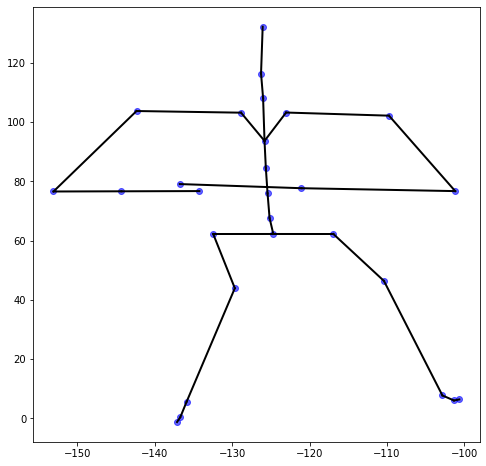

In [ ]:
viz_tools.draw_stickfigure(anger_positions[0], 484)

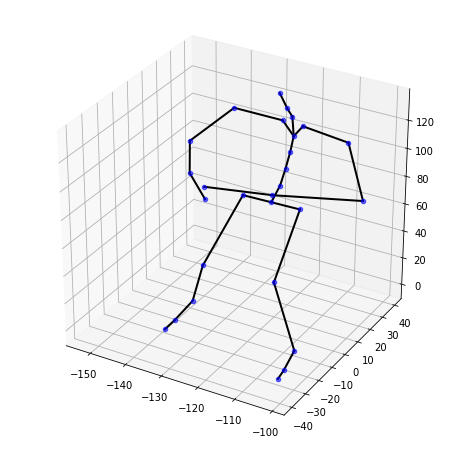

In [ ]:
viz_tools.draw_stickfigure3d(anger_positions[0], 484)

In [ ]:
anger_mocap.get_joints()

[ROOT Hips,
 JOINT Chest,
 JOINT Chest2,
 JOINT Chest3,
 JOINT Chest4,
 JOINT Neck,
 JOINT Head,
 JOINT RightCollar,
 JOINT RightShoulder,
 JOINT RightElbow,
 JOINT RightWrist,
 JOINT LeftCollar,
 JOINT LeftShoulder,
 JOINT LeftElbow,
 JOINT LeftWrist,
 JOINT RightHip,
 JOINT RightKnee,
 JOINT RightAnkle,
 JOINT RightToe,
 JOINT LeftHip,
 JOINT LeftKnee,
 JOINT LeftAnkle,
 JOINT LeftToe]

In [ ]:
anger_mocap.data.splitlines()

In [ ]:
len(anger_mocap.get_joints())

23

In [ ]:
# Processing and joint transformation on data

In [ ]:
# view data again

In [ ]:
# train the model with different hyper parameters

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# results.